# AST/STAT 5731 Project 2
Group 5: Darya Biparva, Xiaoxiao Kou, John Miller Jr, Sam Penders

# Introduction

In 1976 R. Tully and J. Fisher discovered a "new method of determining distances to galaxies," which would later be called the Tully-Fisher relation (TFR). This relation is an empirical, linear relationship between a spiral galaxy's luminosity and rotational velocity. Therefore, measuring a spiral galaxy's emission line width, and thus rotational velocity, would result with an estimate of the galaxy's absolute magnitude. In conjunction with the object's apparent magnitude, the object's distance can then be estimated from the distance modulus equation. With one simple measurement, the TFR provides local distance measurements for the cosmic distance ladder. However, the accuracy of those distances depends on the accuracy of the observed linear relationship.

\
The TFR for three different wavelength ranges, K, H, and J were derived by Masters, Karen L. et al in 2008. The TFR in K was found to be:
> $M_K = 2.238 - 10.017 \log(V)$

where $M_K$ is the absolute K magnitude and V is rotational velocity. The determination of the slope intercept and slope were based on observations from 2005 - 2006. However, how would new K-band observations change these parameters?

\
The goal of the current project is to determine how the K-band TFR parameters from Karen et al. 2008 change based on new K-band observations of rotation dominated galaxies from Tiley et al. 2019. 

\
Tiley et al. 2019 contains data from two different observational studies: SAMi and KROSS. The SAMI survey observed galaxies at z $\approx$ 0, whereas the KROSS survey observed galaxies at z $\approx$ 1. Although a redshift range of z = 0 - 1 does not appear to affect the TFR, only the SAMI data will be utilized for the current analysis. Additionally, the authors further categorize the objects into disky galaxies and rotation dominated galaxies. In general, rotation dominated galaxies tend to have a Hubble type of Sb or later and disky galaxies tend to be Sa or earlier (i.e. disky galaxies tend to be more elliptical in nature.) Since the original TFR was derived from spiral galaxies, only rotation dominated galaxies will be utilized in our analysis. 116 observations remain after all of the filters have been applied.

\
The Tiley et al. 2019 data contains the survey, object ID, subsample flag, log of the intrinsic rotation velocity (logV), velocity error, stellar mass, mass error, absolute K-band magnitude, and magnitude error. The subsample flag = 0 for rotation dominted galaxies and = 1 for both rotation dominated and disky. Therefore, to ensure that all objects are rotation dominated, only galaxies with flag = 0 will be used in our analysis.

\
Reference
> Tully, R. B., Fisher, J. R. 1976, A&A, 54
> 
> Masters, Karen L. et al. 2008, AJ, 135, 1738
>
> Tiley, A. L. et al. 2019, MNRAS, 482, 2

# Statistical Model

Our data consists of $p = 116$ values of the covariate $X^*_i$ and response $Y^*_i$, which we assume are the true values of $X_i$ and $Y_i$ with normal errors, for $i \in \{1, 2, \dots, 116\}$. Thus, this is a normal linear regression problem:

1. Model and parameters:
> $Y_i^* \,|\, Y_i \sim \mathrm{N}(Y_i,\, a^2)$
>
> $Y_i \,|\, X_i^* \sim \mathrm{N}(X_i^*\beta,\, \tau^{-1})$
>
> $X_i^* \,|\, X_i \sim \mathrm{N}(X_i,\, b_i^2)$
>
> $X_i \sim \mathrm{N}(m,\, c^2)$
>
> $\beta \sim \mathrm{N}_2(B,\, G^2)$
>
> $\tau \sim \mathrm{Gamma}(e, f)$

2. Parameter Space: 
> $X_i^*, X_i, Y_i, Y_i^* \in \mathbb{R}$
> 
> $\beta_0 \in (-\infty,\infty)$
>
> $\beta_1 \in (-\infty,\infty)$
>
> $\tau \in [0,\infty)$

3. Data Characteristics: 
> $Y_i = M_K$ and $X_i = \log V$

4. Sample Space: 
> $(X_i^*, Y_i^*) \in \mathbb{R}^2$.

5. Likelihood: 
> $\mathcal{L}(X^* \,|\, X,\, b^{-1},\, m,\, c^{-1}) =  \prod_{i=1}^p \phi(X_i,\, b_i^{2}) \phi(m,\, c^2)$
> 
> Where $\phi$ is the density function for the normal distribution.

6. Priors: 
> $a$ = Errors on $Y$ ($M_k$) in dataset 
>
> $b$ = Errors on $X$ ($\log V$) in dataset
>
> $m = c = 2$
>
> $B = (2.25, -10.02)$ 
>
> $G =\begin{bmatrix}
5 & 0 \\
0 & 10.2
\end{bmatrix}$
>
> $e = f = 0.5$

The estimated errors on $X$ and $Y$ in the data can be thought of as the standard deviations on these values. We choose the parameters $m = c = 2$ for $X$ because the physical quantity $\log V$ for a galaxy will almost always be within the range 0 to 4. We choose prior mean values for $\beta$ to match values from the literature, and pick the standard deviations on $\beta$ based on the assumption that the true value is within a factor of two of the reported values. Finally, the priors on $\tau$ give it a mean of one, which seems like a reasonable assumption based on the typical spread of measurements of $M_k$.


## Analysis

In [ ]:
import pandas as pd
from astropy.io import ascii
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
from pymc import Normal, Gamma, find_MAP
import arviz as az
import xarray as xr
from scipy.stats import linregress, multivariate_normal, gamma, norm

! pip install watermark
! pip install corner
import corner
import watermark

## Project Reproducibility:

Our Model was developed using Python 3.7 based on Google Colab Collorbation. We show below relevant packages and their versions for our project.

In [2]:
# print library versions used
%load_ext watermark
%watermark -n -u -v -iv -w -p xarray

Last updated: Wed Nov 23 2022

Python implementation: CPython
Python version       : 3.7.15
IPython version      : 7.9.0

xarray: 0.20.2

corner    : 2.2.1
pymc      : 4.1.4
astropy   : 4.3.1
arviz     : 0.12.1
pandas    : 1.3.5
seaborn   : 0.11.2
numpy     : 1.21.6
matplotlib: 3.2.2
watermark : 2.3.1
xarray    : 0.20.2

Watermark: 2.3.1



## Filter to rotation-dominated galaxies and the SAMI-matched data

In order to obtain a more accurate estimate of the parameters, we decided to limit ourselves to rotation-dominated galaxies (instead of including disky galaxies) and filtering the data only to include objects with z=0. This way, we will just have parameters compatible with local rotation-dominated galaxies.

In [3]:
# importing data from CDS
df = ascii.read("https://cdsarc.cds.unistra.fr/ftp/J/MNRAS/482/2166/tablea1.dat", \
                   readme="https://cdsarc.cds.unistra.fr/ftp/J/MNRAS/482/2166/ReadMe").to_pandas() 
# filter to galaxy type and survey
df = df[ (df['f_ID'] == 0) & (df['Survey'] == 'SAMI_matched')]

df.describe()

,ID,f_ID,logv2.2,e_logv2.2,logMstar,e_logMstar,KMAG,e_KMAG
count,116.000000,116.0,116.000000,116.000000,116.000000,1.160000e+02,116.000000,116.000000
mean,356891.784483,0.0,1.832241,0.062218,9.505310,2.000000e-01,-22.003819,0.117784
std,199399.132787,0.0,0.253144,0.030313,0.823209,2.787599e-17,1.612225,0.221138
min,16487.000000,0.0,1.310065,0.013526,7.779980,2.000000e-01,-25.278000,0.005000
25%,203383.250000,0.0,1.642971,0.037924,8.911392,2.000000e-01,-23.231250,0.015000
50%,371924.000000,0.0,1.810939,0.056345,9.385685,2.000000e-01,-22.022000,0.040000
75%,537196.750000,0.0,2.008103,0.083971,10.221175,2.000000e-01,-20.717750,0.100500
max,622534.000000,0.0,2.452462,0.127690,11.138100,2.000000e-01,-18.671000,1.000000


A couple of remarks about the data:


*   116 data points
*   Mean of the error for log(v) is 0.06 and the maximum error for it is 0.12
*   Mean of the error for $M_K$ is 0.11 and the maximum error is 1

There are appreciable errors in both the covariate and response variables, so a linear regression should take errors on both into account.



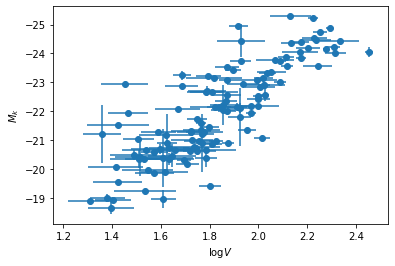

In [4]:
fig, ax = plt.subplots()
ax.scatter(df['logv2.2'], df['KMAG'])
ax.errorbar(df['logv2.2'], df['KMAG'], 
            xerr = df['e_logv2.2'], yerr = df['e_KMAG'],
            fmt='none')
ax.set_xlabel(r'$\log V$')
ax.set_ylabel(r'$M_k$')
ax.invert_yaxis()

We can clearly see a linear dependency between the components.

Now, we estimate the regression parameters with a frequentist MLE:

In [5]:
# linear regression using scipy
x = df['logv2.2']
y = df['KMAG']
regress = linregress(x, y)
print("slope and stderr: ", regress.slope, regress.stderr)
print("intercept and stderr: ", regress.intercept, regress.intercept_stderr)
print('p value for this regression', regress.pvalue)

slope and stderr:  -5.256502915455244 0.3367921868543615
intercept and stderr:  -12.372639126993139 0.6228958783879923
p value for this regression 4.5120129570897305e-30


A couple of points worth mentioning:

The standard error is calculated in scipy under the assumption that residuals are normal.

The pvalue confirms that these variables have a linear relationship.

The line depicted below is the result of frequentist analysis on data


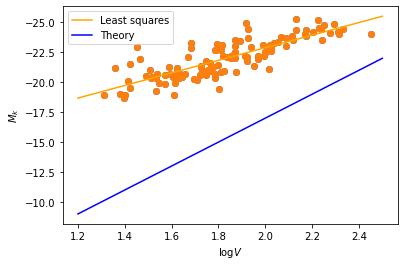

In [6]:
# Plot of OLS regression
slope = regress.slope
intercept = regress.intercept
xfit = np.arange(1.2, 2.6, 0.1)
yfit = slope * xfit  + intercept

# initializing plot
fig, ax = plt.subplots()
ax.set_xlabel(r'$\log V$')
ax.set_ylabel(r'$M_k$')
ax.invert_yaxis()

# plotting!
ax.scatter(x, y)
ax.plot(xfit, yfit, color='orange', label="Least squares")
print('The line depicted below is the result of frequentist analysis on data')

# fit line from parameters from textbook
y_theory = -10*xfit + 3
ax.scatter(x, y)
ax.plot(xfit, y_theory, color='blue', label="Theory")
ax.legend(); plt.show()

We note that the result of frequentist inference on our data differs significantly (visually, but we're sure a statistical test would also suggest the same) from the equation in Carroll & Ostlie and in Masters 2008. The difference between these two lines could be due to inaccuracies in measurements, or due to some astrophysical reasons. We will note this difference for now and explore the reasoning at the end of our analysis.

# Bayesian linear regression

## Standard Reference Prior

Before we consider a more detailed model where measurement errors in the covariate and response are modeled, we first use a normal Bayesian regression model using the standard reference priors to compare our final results to. This standard reference prior model is:

> $Y_i \,|\, X_i, \beta, \tau \sim \mathrm{N}(X_i\beta, \tau)$
>
> $ \beta \,|\, \tau \sim \mathrm{N}(\hat{\beta}, \tau(X_i^T X_i)^{-1})$
>
> $\tau  \sim \mathrm{Gamma}(\frac{n - p}{2},\, \mathrm{SSE}/2)$

Where $n = 116$ is the number of data points, $p = 2$ is the dimensionality of $\beta$, $\hat{\beta}$ is the MLE esimate for $\beta$, and SSE is the usual sum of squared errors.

In [7]:
logV = df['logv2.2']
e_logV = df['e_logv2.2']
M = df['KMAG']
e_M = df['e_KMAG']

Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


         mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta0 -12.383  0.566   -13.514    -11.270      0.010    0.007    3227.0   
beta1  -5.251  0.306    -5.823     -4.608      0.005    0.004    3230.0   
tauy    1.206  0.111     0.979      1.418      0.002    0.001    4013.0   

       ess_tail  r_hat  
beta0    2913.0    NaN  
beta1    2990.0    NaN  
tauy     4186.0    NaN  


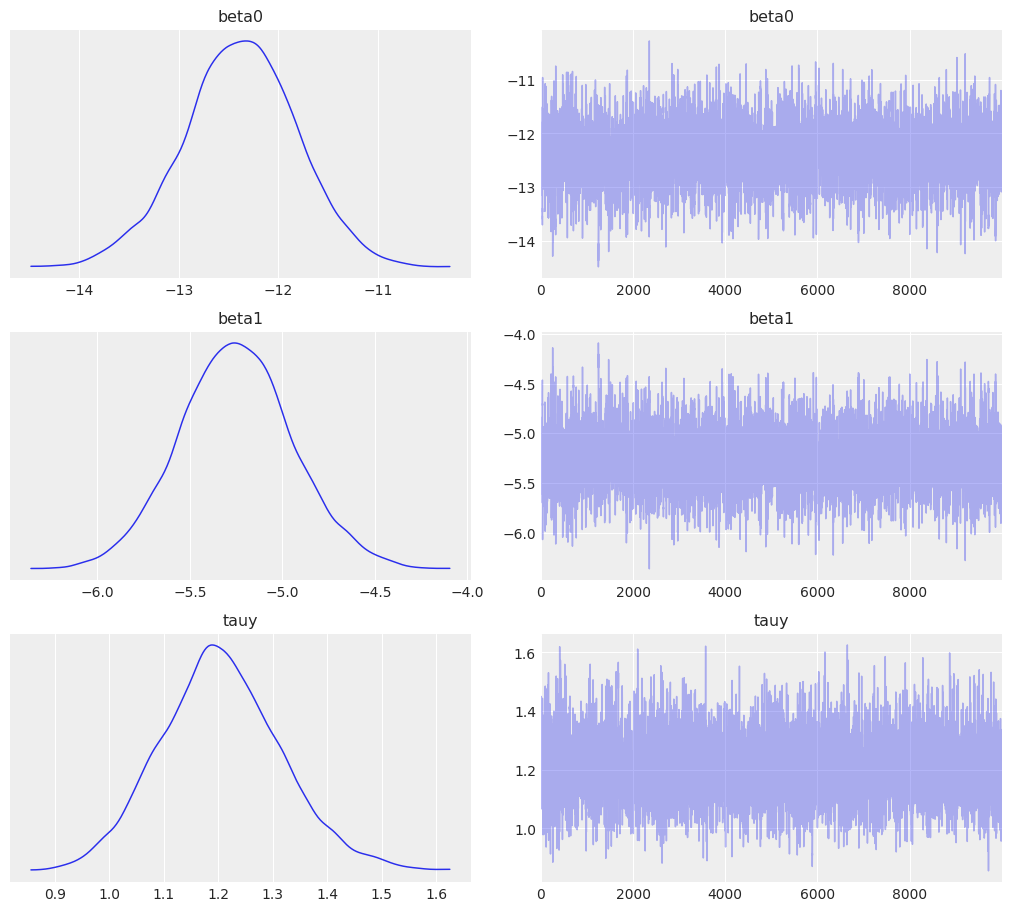

In [8]:
x = logV
y = M.to_numpy()

n = len(x)
p = 2
x = x.to_numpy()
x = np.stack((np.ones(n), x), axis=1)


xTxinv =  np.linalg.inv(np.matmul(x.T, x))
xTy = np.matmul(x.T, y)
# MLE estimate of beta
beta_hat = np.matmul(xTxinv, xTy)

err = y - np.matmul(x, beta_hat)
sse = np.matmul(err.T, err)

with pm.Model() as simple_model:
    # priors
    tauy = Gamma('tauy', alpha=(n-p)/2, beta=0.5*sse)
    b0_tau = np.linalg.inv(np.matmul(x.T, x))[0,0] * tauy
    b1_tau = np.linalg.inv(np.matmul(x.T, x))[1,1] * tauy
    beta0 = Normal('beta0', mu=beta_hat[0], tau=b0_tau)
    beta1 = Normal('beta1', mu=beta_hat[1], tau=b1_tau)

    XB = beta0 + beta1 * logV
    Y_obs = Normal('Y_obs', mu=XB, tau=tauy, observed=M, shape=n)
    
    # run model
    RANDOM_SEED = 5731
    rng = np.random.default_rng(RANDOM_SEED)
    az.style.use("arviz-darkgrid")

    trace = pm.sample(return_inferencedata=True, 
                        draws=10000,
                        chains=1)
    
    vars = ['beta0', 'beta1', 'tauy']
    az.plot_trace(trace, figsize=(10, 9), var_names=vars)
    print(az.summary(trace.posterior[["beta0", "beta1","tauy"]], hdi_prob=0.95))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5fdf1b0410>,
      dtype=object)

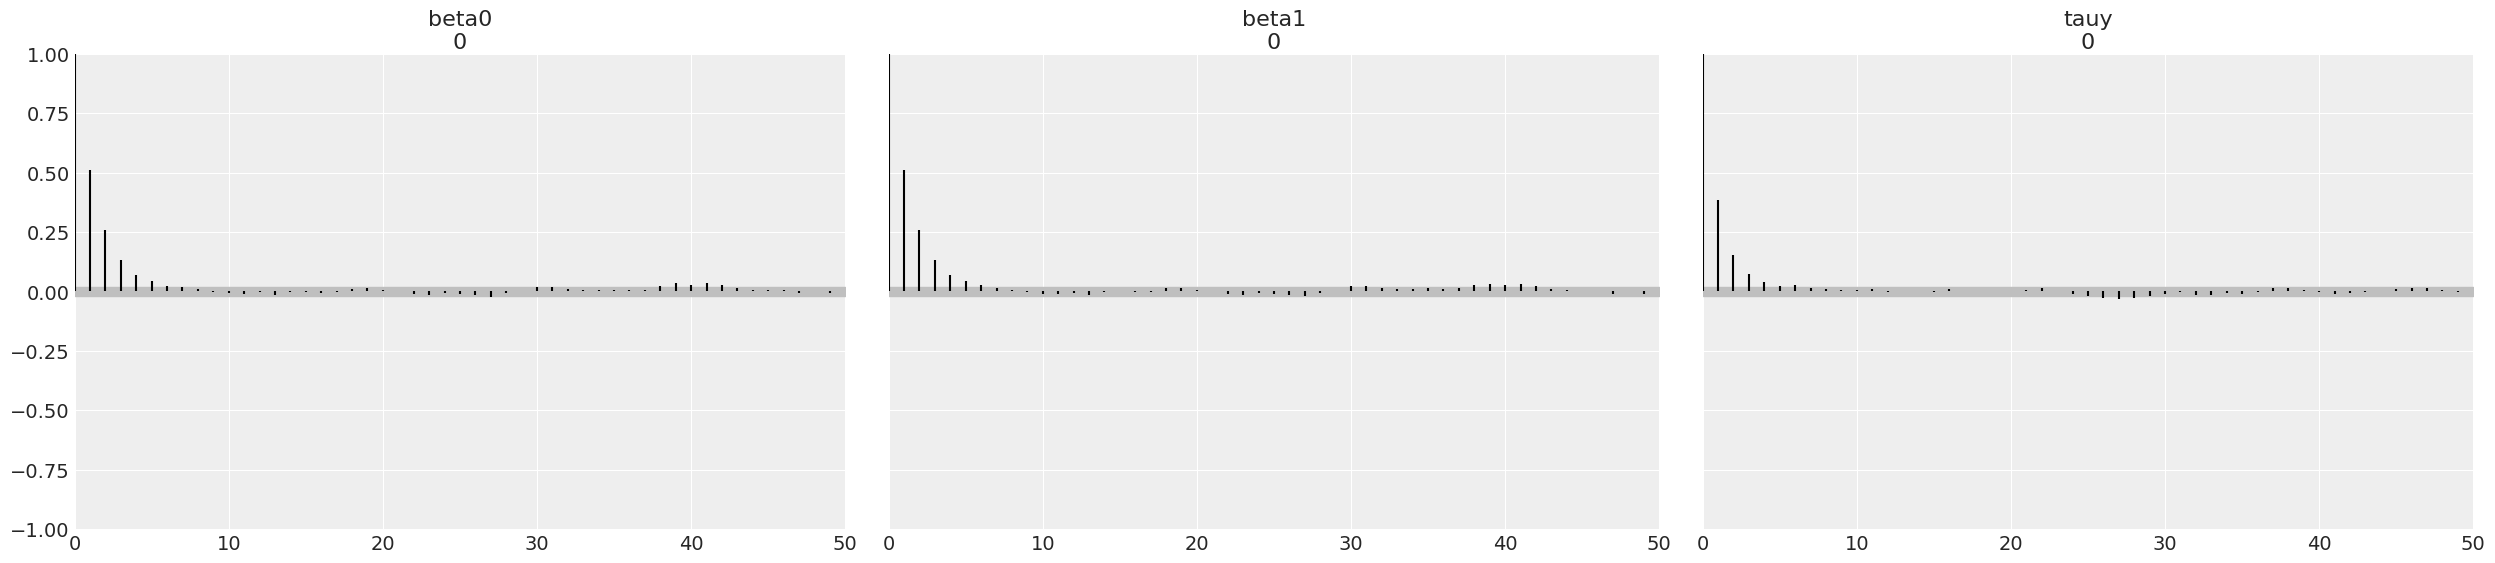

In [9]:
# Autocorrelation plots
az.plot_autocorr(trace, var_names=vars, filter_vars="like", max_lag = 50)

As expected for the standard reference prior model, the posterior mean values for $\beta$ match the MLE estimates calculated in the introduction.

We note that the ACF plots show that the samples drawn are not correlated to one another. Thus, we can trust our bayesian analysis.

The mean values and 95% confidence intervals for our posterior parameters are:

$\beta_{0} = -12.376$ with 95% confidence interval: $(-13.461, -11.168)$

$\beta_{1} = -5.254$ with 95% confidence interval: $(-5.865, -4.619)$

$\tau_{y} = 1.187$ with 95% confidence interval: $(0.966, 1.407)$

# Bayesian linear regression with errors modeled in $X$ and $Y$


Now, we build a bayesian model that incorporates measurement error on both X and Y observations. Then to make sure our priors do not make predictions significantly different from our data, we do a prior predictive check.

As discussed in the introduction, our priors are based on values given for the Tully-Fisher Relation in the literature.

In [10]:
# Priors on errors with Gamma distribution
# tauy ~ Gamma(alpha=ey, beta=fy)
ey = fy = 0.5

# Prior fit parameters for Sb galaxies (rotation-dominated)
beta0_prior = 2.24
beta1_prior = -10.02

# prior precision on logV (X)
mu_x = 2
mu_sigma = 2

with pm.Model() as model:
    # Assume prior slope was within factor of 2 of true value
    beta0 = Normal('beta0', mu=beta0_prior, sigma=5)
    beta1 = Normal('beta1', mu=beta1_prior, sigma=np.abs(beta1_prior))

    tauy = Gamma('tauy', alpha=ey, beta=fy)

    X = Normal('X', mu=mu_x, sigma=mu_sigma, shape=M.shape)
    XB = beta0 + beta1 * X
    Y = Normal(name='Y', mu=XB, tau=tauy, shape=logV.shape)

    X_obs = Normal('X_obs', mu=X, sigma=np.abs(e_logV), observed=logV)
    Y_obs = Normal('Y_obs', mu=Y, sigma=np.abs(e_M), observed=M)

## Prior Predictive Check

By sampling values of $\beta_0$ and $\beta_1$ from our prior densities, we see that the priors generate relatively reasonable predictions.

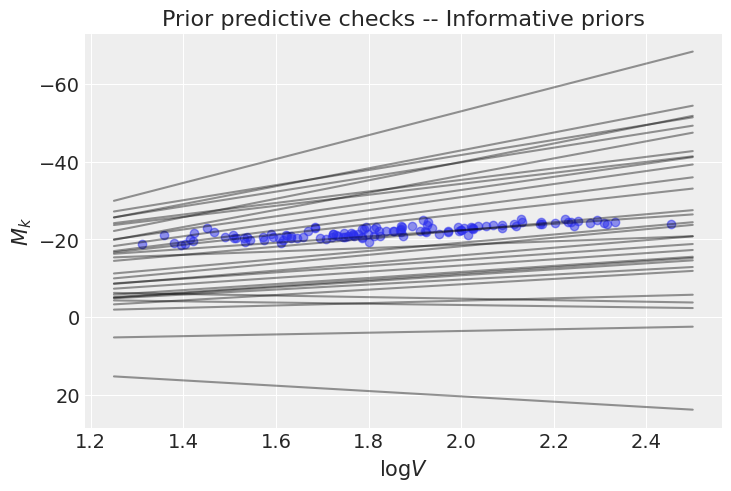

In [11]:
# initalizing plot
_, ax_prior = plt.subplots()
ax_prior.set_title("Prior predictive checks -- Informative priors");
ax_prior.set_xlabel(r"$\log V$")
ax_prior.set_ylabel(r"$M_k$")
ax_prior.invert_yaxis()

# pymc model
with model:
  idata = pm.sample_prior_predictive(samples=30, random_seed=rng)

# plotting!
x_dim = xr.DataArray(np.linspace(1.25, 2.5, 116), dims=["plot_dim"])
prior = idata.prior
y = prior["beta0"] + prior["beta1"] * x_dim

ax_prior.plot(np.linspace(1.25, 2.5, 116), y.stack(sample=("chain", "draw")), c="k", alpha=0.4)
ax_prior.scatter(df['logv2.2'], df['KMAG'],alpha=0.5)
plt.show()

The above model is built according to the statistical model described before. Our model setup together with our prior parameter choice can sufficiently cover our observed data, as shown from the figure above.

## Posterior

We now sample to return the posterior.

In [12]:
# run model
RANDOM_SEED = 5731
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

with model:
    trace = pm.sample(return_inferencedata=True, 
                      draws=10000,
                      chains=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5fd24cb910>,
      dtype=object)

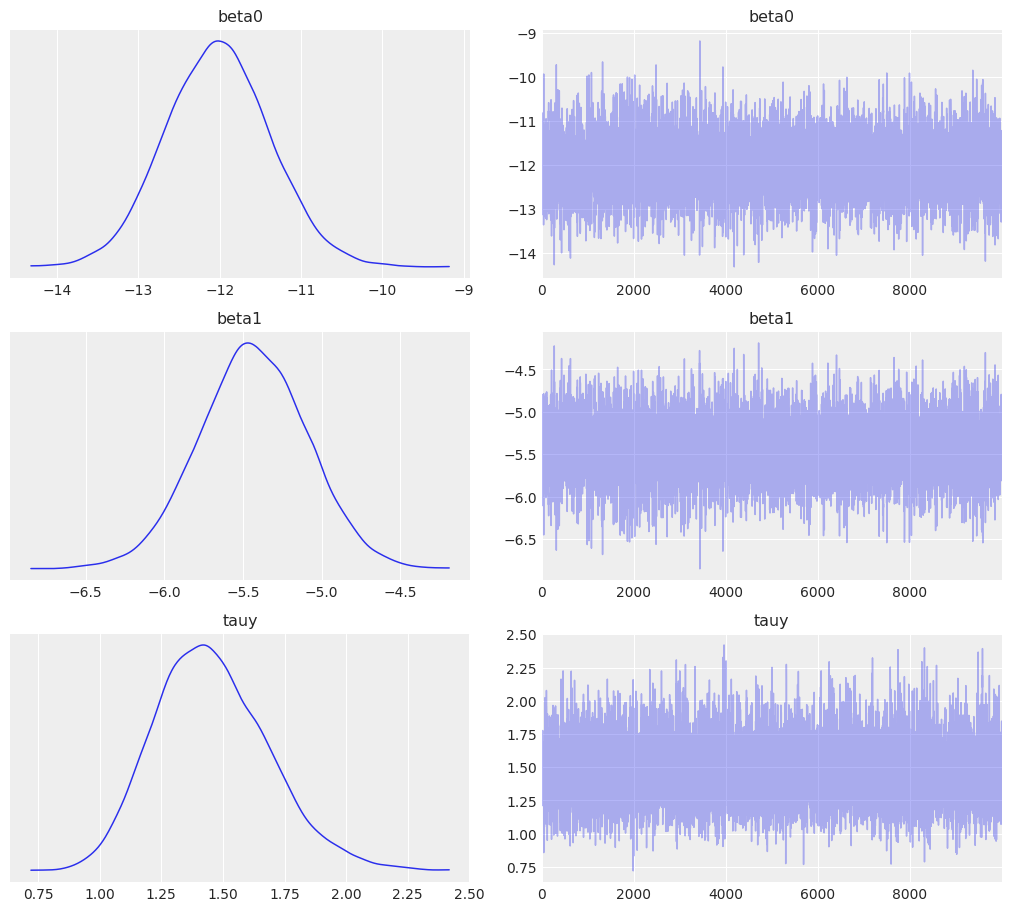

In [13]:
vars = ['beta0', 'beta1', 'tauy']
az.plot_trace(trace, figsize=(10, 9), var_names=vars)

The above plots show our drawn samples for $\beta_{0}, \beta_{1}, \tau_{y}$. We see no apparent correlation between samples. and also the posterior distribtution seems reasonalbe. They are centered close to our standard reference prior/MLE estimate.


In [14]:
az.summary(trace.posterior[["beta0", "beta1","tauy"]], hdi_prob=0.95)

Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,-12.022,0.646,-13.288,-10.752,0.009,0.006,5467.0,6055.0,NaN
beta1,-5.436,0.345,-6.117,-4.775,0.005,0.003,5492.0,6014.0,NaN
tauy,1.457,0.232,1.017,1.912,0.003,0.002,8075.0,6938.0,NaN


## Results:

Our model with errors on $X$ and $Y$ gives us the following estimates of the parameters and 95% confidence intervals:
* $\beta_0$ = 12.028 (-13.278, -10.794)
* $\beta_1$ = -5.433 (-6.099, -4.778)
* $\tau$ = 1.463 (1.022, 1.930)

These values agree well with both the MLE estimates and the standard reference prior. In order to check how reliable our estimates our we need to check the ACF plots of the samples we have drawn by NUTS sampler. 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5fdaf94e90>,
      dtype=object)

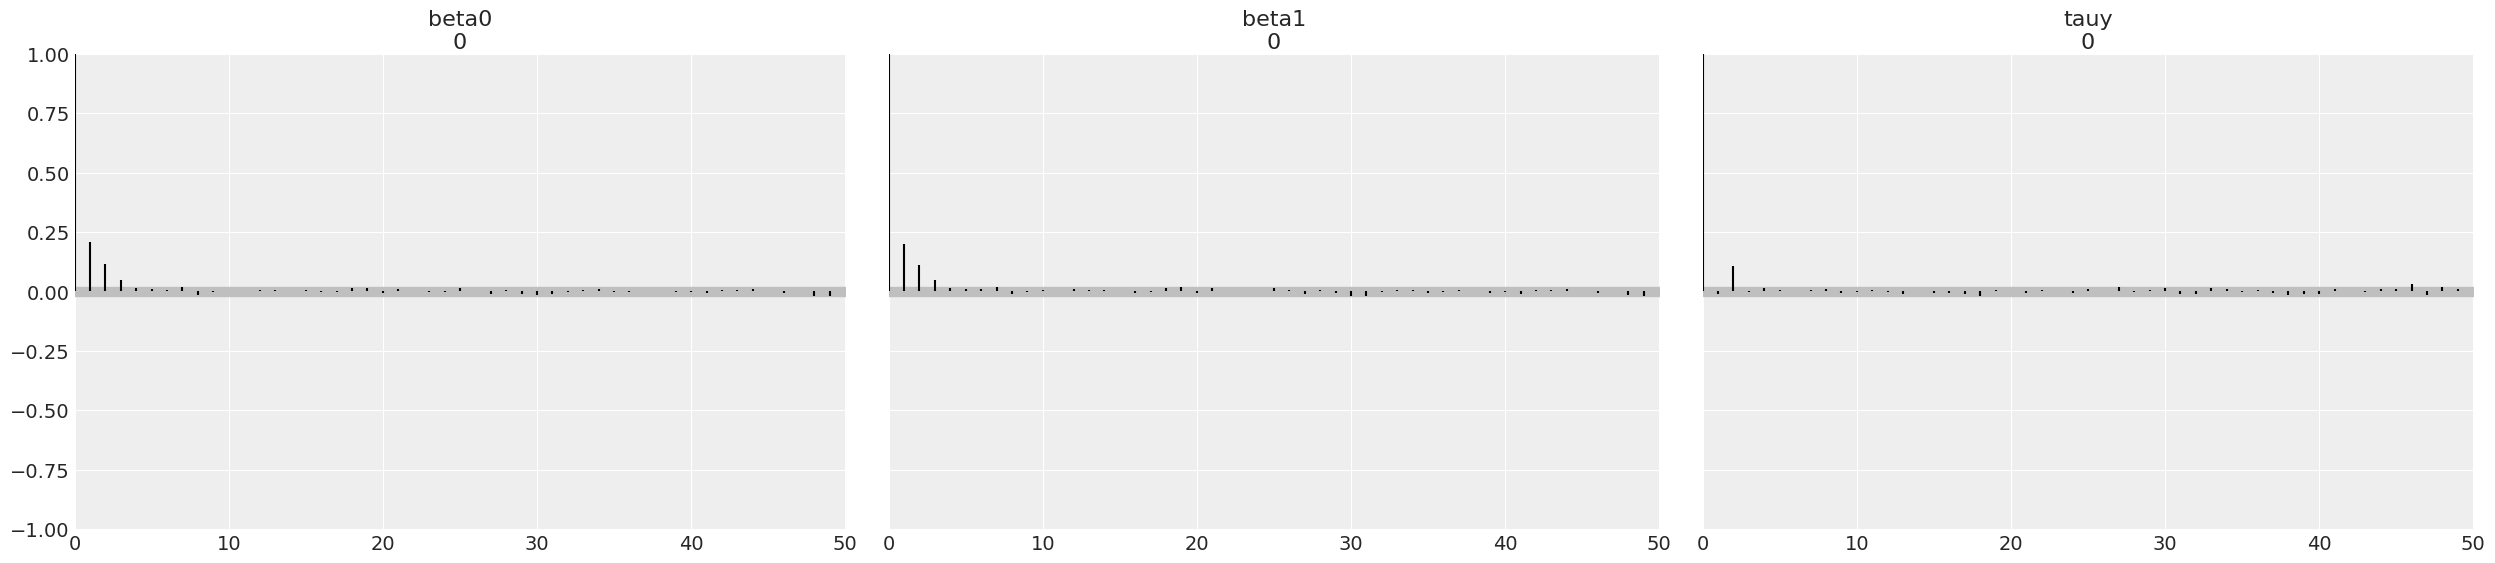

In [15]:
# Autocorrelation plots
az.plot_autocorr(trace, var_names=vars, filter_vars="like", max_lag = 50)

The acf plots show that all parameters have an autocorrelation function that is negligible after lag = 3, which means that our drawn samples are reliable.

#Visualizing the 95% confidence interval for our estimation of parameters.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5fe3f24550>,
      dtype=object)

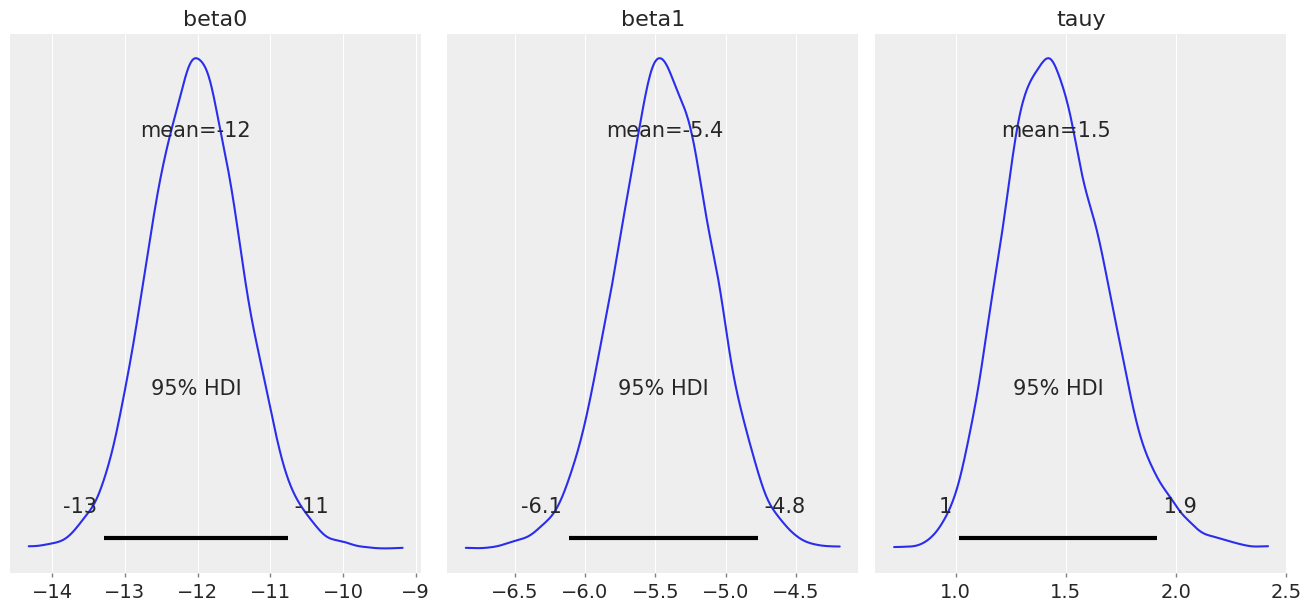

In [16]:
az.plot_posterior(trace.posterior[["beta0", "beta1", "tauy"]],figsize=(13, 6), hdi_prob=0.95)

# Visualizing our estimates of the parameters both with measurement error and without it.

By plotting the lines corresponding to our $\beta$ values the model with errors and the standard reference prior, we see the results are very similar.

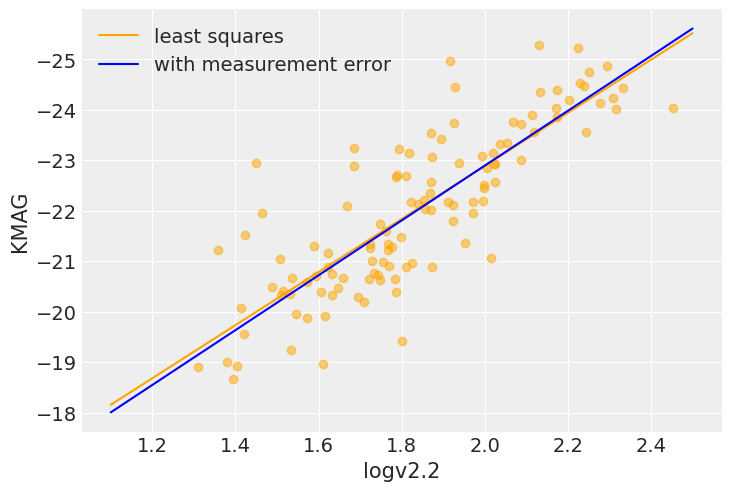

In [17]:
# parameters
post_beta0 = -12.029
post_beta1 = -5.433
slop_ls = -5.26
intercept_ls = -12.37
xfit = np.arange(1.1, 2.6, 0.1)
yfit = slop_ls * xfit + intercept_ls
x = df['logv2.2']
y = df['KMAG']

# initializing plot
fig, ax = plt.subplots()
ax.set_xlabel('logv2.2')
ax.set_ylabel('KMAG')
ax.invert_yaxis()

# plotting!
ax.scatter(x, y, alpha=0.5,c='orange')
ax.plot(xfit, yfit, color='orange', label="least squares")
y_post = post_beta1 * xfit + post_beta0
ax.plot(xfit, y_post, color='blue', label="with measurement error")
ax.legend(); plt.show()

## Posterior Predictive
Below, we sample the posterior densities and make a posterior predictive plot of the observed values of $\log V$ and $M_k$ for 50 samples, each with 116 data points. We also sample the posterior density of $\beta$, and with those values, plot 100 regression lines of the form $y = \beta_0 + \beta_1 x$ over the observed data.

From this, we see that the posterior densities generate similar data to our observed data. We also see that the posterior distribution of $\beta$ creates a narrow range of regression lines, all of which fit the data well. 

In [18]:
with model:
  idata = pm.sample_posterior_predictive(trace, random_seed=rng)

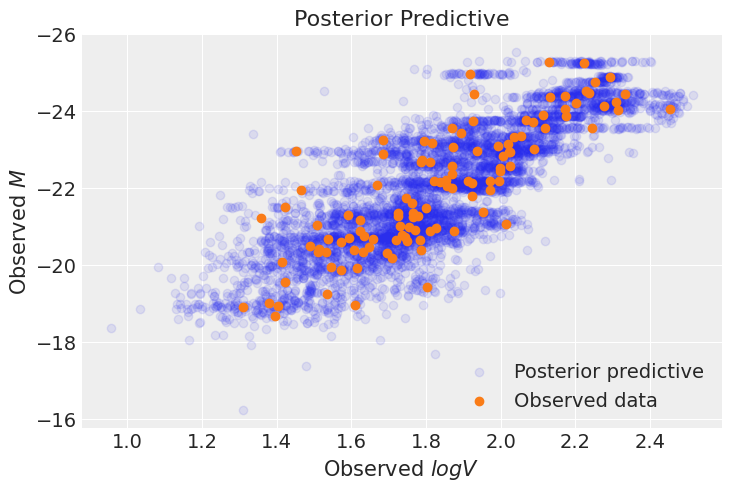

In [19]:
x = idata.posterior_predictive["X_obs"].values[:, 1:50, :]
y = idata.posterior_predictive["Y_obs"].values[:, 1:50, :]
plt.scatter(x, y, alpha=0.1, label="Posterior predictive")
plt.scatter(logV, M, label="Observed data")
plt.xlabel(r"Observed $log V$")
plt.ylabel(r'Observed $M$')
plt.title('Posterior Predictive')
plt.legend()
plt.gca().invert_yaxis()

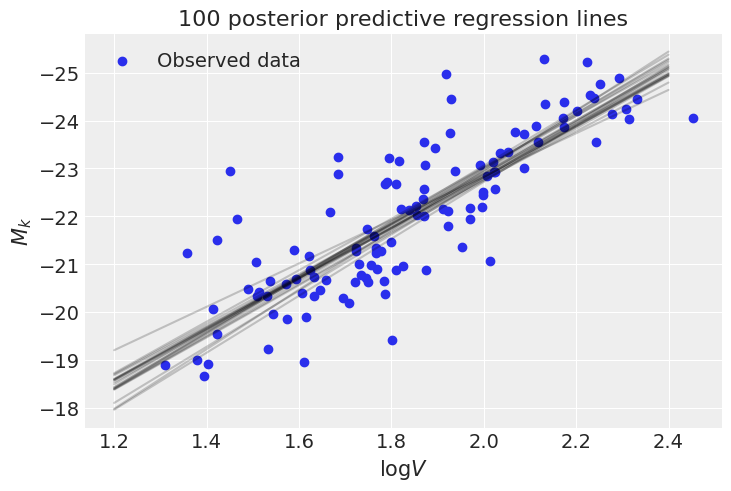

In [20]:
b0 = trace.posterior['beta0'].values
b1 = trace.posterior['beta1'].values

x = np.arange(1.2, 2.6, 0.2)

n = 100
fig, ax = plt.subplots()
for i in range(0, 20*n, n):
    intercept = b0[0, i]
    slope = b1[0, i]
    y = intercept + x * slope
    ax.plot(x, y, color='k', alpha=0.2)

ax.scatter(logV, M, label='Observed data')
ax.set_xlabel(r'$\log V$')
ax.set_ylabel(r'$M_k$')
ax.set_title(r'100 posterior predictive regression lines')
plt.legend()
ax.invert_yaxis()

/usr/local/lib/python3.7/dist-packages/corner/core.py:104: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  left=lb, bottom=lb, right=tr, top=tr, wspace=whspace, hspace=whspace


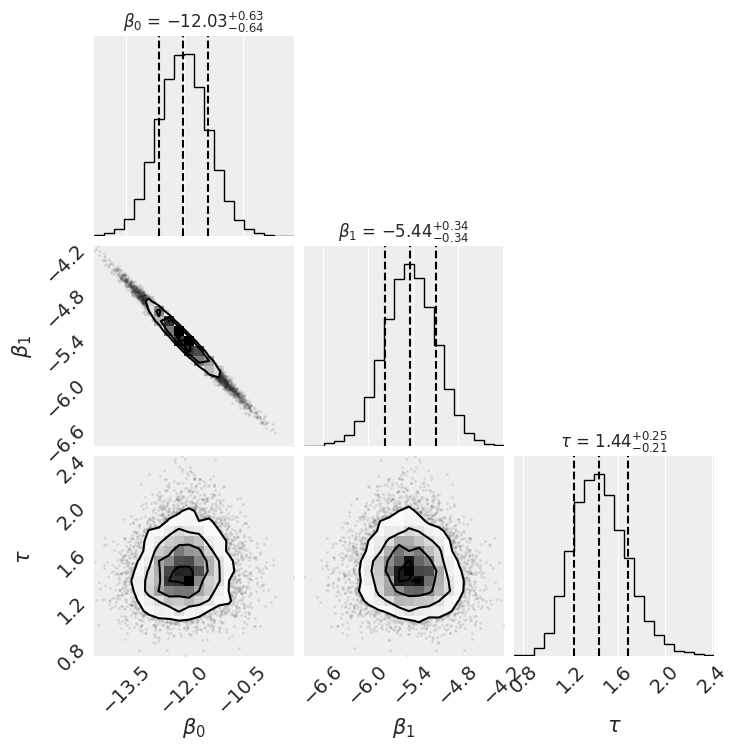

In [21]:
labels = [r"$\beta_0$",r"$\beta_1$",r"$\tau$"]
fig = corner.corner(
    trace, var_names=['beta0', 'beta1','tauy'],labels=labels,quantiles=[0.16, 0.5, 0.84],
    show_titles=True,divergences=True,title_kwargs={"fontsize": 12}
);

Inference on our model's slope ($\beta_0$), intercept ($\beta_1$) and errors $\tau$ from MCMC simulations. The dashied vertical lines indicate 95% CLs. There is a correlation between the $\beta$s, but this is expected in this kind of Bayesian model.

## Sensitivity analysis

We pick a variety of different priors on $\beta$ and $\tau$ to see how sensitive the analysis is to these choices.

[(1, 1, 0, 1, 0), (0.5, 0.5, 1, -5, 2), (2, 2, -2, 10, -2)]


Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


         mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta0 -13.358  0.624   -14.609    -12.163      0.008    0.006    5881.0   
beta1  -4.718  0.334    -5.366     -4.060      0.004    0.003    5920.0   
tauy    1.360  0.217     0.959      1.800      0.002    0.002    8750.0   

       ess_tail  r_hat  
beta0    6249.0    NaN  
beta1    6114.0    NaN  
tauy     7782.0    NaN  


ERROR:pymc:There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


         mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta0 -12.067  0.639   -13.230    -10.731      0.008    0.006    6714.0   
beta1  -5.413  0.339    -6.105     -4.783      0.004    0.003    6804.0   
tauy    1.456  0.226     1.026      1.904      0.003    0.002    8427.0   

       ess_tail  r_hat  
beta0    6658.0    NaN  
beta1    6800.0    NaN  
tauy     5292.0    NaN  


Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


         mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta0 -12.172  0.638   -13.411    -10.899      0.009    0.006    4878.0   
beta1  -5.357  0.341    -6.048     -4.709      0.005    0.003    4793.0   
tauy    1.429  0.221     1.005      1.863      0.002    0.002    8237.0   

       ess_tail  r_hat  
beta0    6209.0    NaN  
beta1    6384.0    NaN  
tauy     7220.0    NaN  


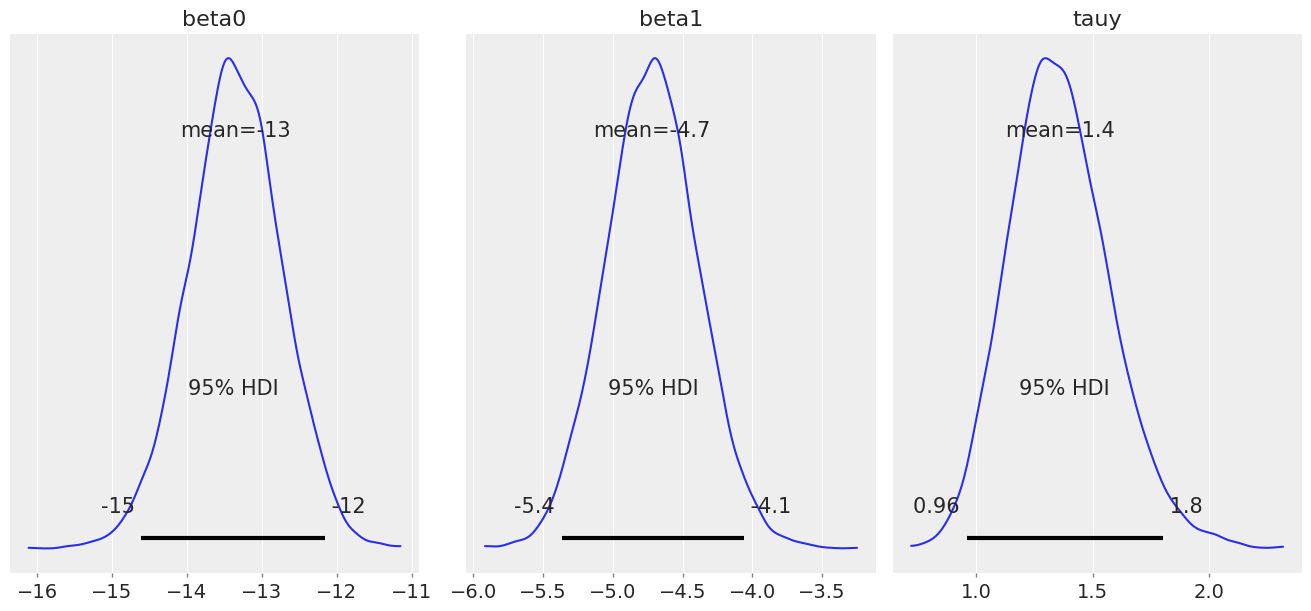

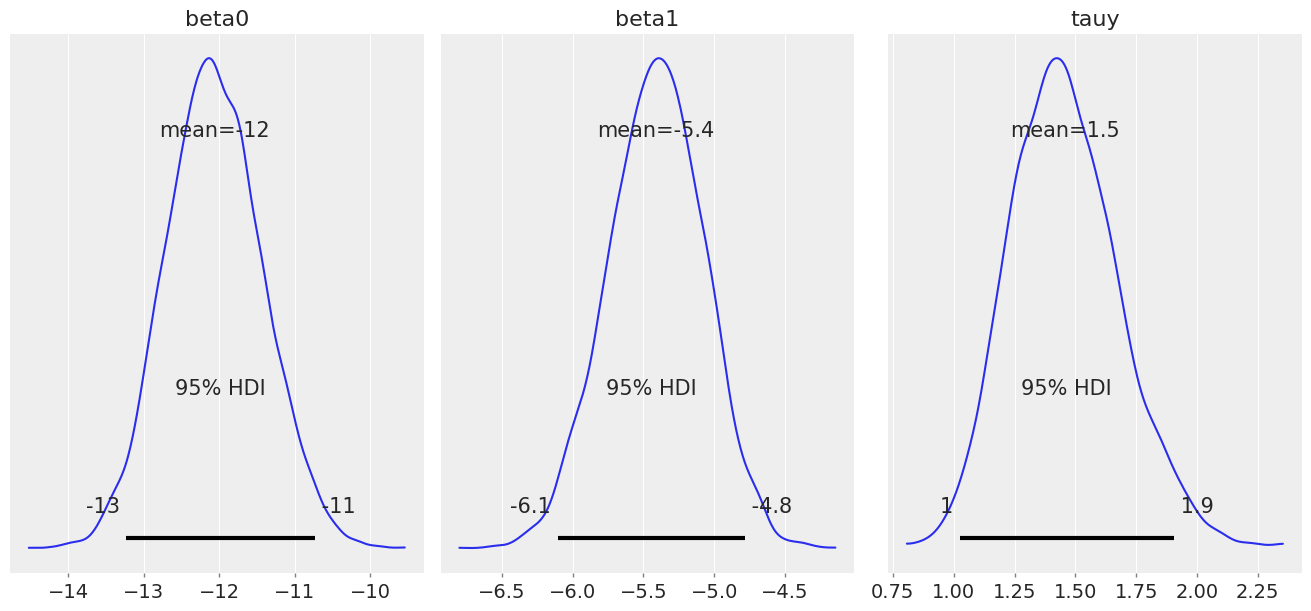

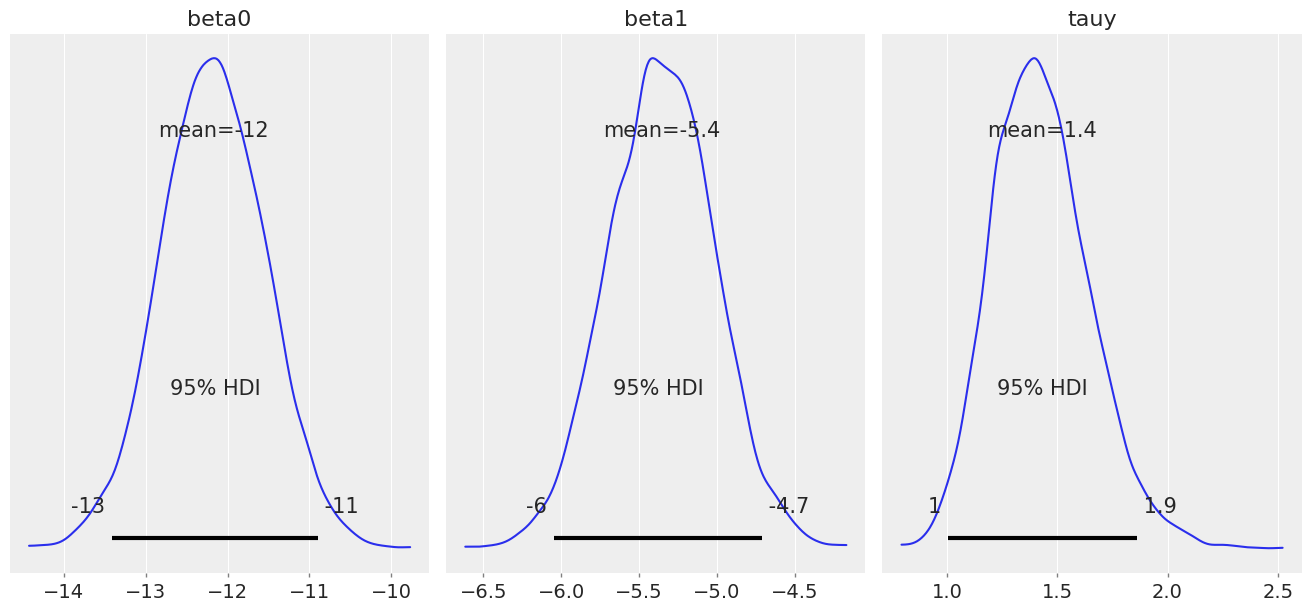

In [22]:
# Priors on errors with Gamma distribution
# taux ~ Gamma(alpha=ex, beta=fx)
# tauy ~ Gamma(alpha=ey, beta=fy)
beta_0_storage = []
beta_1_storage = []
eys = [1, 0.5, 2]
fys = [1, 0.5, 2]
beta0s = [0, 1, -2]
beta1s = [1, -5, 10]
mu_xs = [0, 2, -2]
params = list(zip(eys, fys, beta0s, beta1s, mu_xs))
print(params)
d=1e-5

for param in params:
  ey = param[0]
  fy = param[1]
  beta0_prior = param[2]
  beta1_prior = param[3]
  mu_x = param[4]
# # prior precision on logV (X)


  with pm.Model() as complex_model:
      # Assume prior slope was within factor of 2 of true value
      beta0 = Normal('beta0', mu=beta0_prior, sigma=5)
      beta1 = Normal('beta1', mu=beta1_prior, sigma=np.abs(beta1_prior))

      #taux = Gamma('taux', alpha=ex, beta=fx)
      tauy = Gamma('tauy', alpha=ey, beta=fy)

      #X = Normal('X', mu=0, tau=taux)
      X = Normal('X', mu=mu_x, tau=d, shape=M.shape)
      XB = beta0 + beta1 * X
      Y = Normal(name='Y', mu=XB, tau=tauy, shape=logV.shape)

      X_obs = Normal('X_obs', mu=X, sigma=np.abs(e_logV), observed=logV)
      Y_obs = Normal('Y_obs', mu=Y, sigma=np.abs(e_M), observed=M)
      RANDOM_SEED = 5731
      rng = np.random.default_rng(RANDOM_SEED)
      az.style.use("arviz-darkgrid")

      with complex_model:
          complex_start = find_MAP() 

          complex_trace = pm.sample(initvals=complex_start, 
                            return_inferencedata=True, 
                            draws=10000,
                            chains=1)
          #print(trace.posterior_predictive.beta0.values.mean(),trace.posterior_predictive.beta1.values.mean())
          print(az.summary(complex_trace.posterior[["beta0", "beta1","tauy"]], hdi_prob=0.95))
          beta_0_storage.append(complex_trace.posterior['beta0'].mean())
          beta_1_storage.append(complex_trace.posterior['beta1'].mean())
          az.plot_posterior(complex_trace.posterior[["beta0", "beta1", "tauy"]],figsize=(13, 6), hdi_prob=0.95)

Our sensitivity analysis shows that even though our esimates change with different values for prior parameters. However, the esimates stay within the 95% confidence interval. 

In [23]:
for params in list(zip(eys, fys, beta0s, beta1s, mu_xs, beta_0_storage, beta_1_storage)):
  print("--------------------------------------------------------------------------------------")
  print(r"Prior: (e, f, \beta_0^p, \beta_1^p, \mu_xs) = " + str((params[0],params[1],params[2],params[3], params[4])) 
  + r", Posterior Mean: (\beta_0 = {beta0:.1f}, \beta_1 = {beta1:.2f})".format(beta0=params[5].values,beta1=params[6].values))

--------------------------------------------------------------------------------------
Prior: (e, f, \beta_0^p, \beta_1^p, \mu_xs) = (1, 1, 0, 1, 0), Posterior Mean: (\beta_0 = -13.4, \beta_1 = -4.72)
--------------------------------------------------------------------------------------
Prior: (e, f, \beta_0^p, \beta_1^p, \mu_xs) = (0.5, 0.5, 1, -5, 2), Posterior Mean: (\beta_0 = -12.1, \beta_1 = -5.41)
--------------------------------------------------------------------------------------
Prior: (e, f, \beta_0^p, \beta_1^p, \mu_xs) = (2, 2, -2, 10, -2), Posterior Mean: (\beta_0 = -12.2, \beta_1 = -5.36)


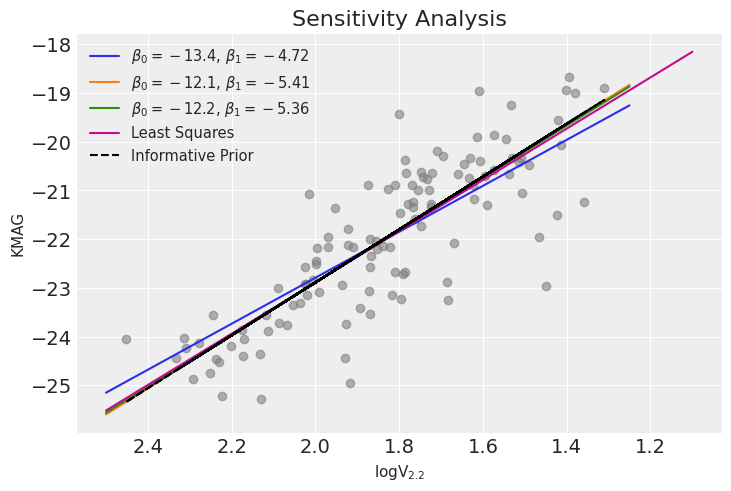

In [24]:
x = np.linspace(1.25, 2.5, 116)

# initializing plot
plt.xlabel(r"$\mathrm{logV}_{2.2}$",fontsize=11)
plt.ylabel("KMAG",fontsize=11)
plt.title("Sensitivity Analysis")
plt.gca().invert_xaxis()

# plotting!
plt.scatter(df['logv2.2'], df['KMAG'],color="grey",alpha=0.6)
for beta in list(zip(beta_0_storage,beta_1_storage)):
  plt.plot(x, beta[0].values + beta[1].values * x, 
           label=r"$\beta_0 = {beta0:.1f}$, $\beta_1 = {beta1:.2f}$".format(beta0 = beta[0].values, beta1 = beta[1].values),)
  
plt.plot(xfit, yfit,label="Least Squares")
plt.plot(logV,-12.03 -5.43 * logV, label="Informative Prior",color="black",linestyle="dashed")
plt.legend(fontsize=10.5)

# Discussion/Conclusion

Our Bayesian normal linear regression has resulted in a well constrained line that fits the Tiley 2019 data well. The line has parameters: $\beta_0$ = -12.0 (-13.2, -10.8), $\beta_1$ = -5.4 (-6.1,-4.8), and $\tau$ = 1.5 (1.0, 1.9). The prior sensitivity analysis demonstrated that choosing a different prior would not result in a significant change in the linear parameters. Additionally, our result is consistent with the least squares method and standard reference prior. 

The only 'issue' with our result comes from the discrepency between the prior parameters and our derived parameters. The parameters from Masters 2008 are $\beta_0$ = 2.238 and $\beta_1$ = 10.017. Our $\beta_1$ is only about \~1/5 from the prior $\beta_1$, but our intercept is considerably off from the prior (\~7). This result is not borne from our analysis, but instead from characteristics of our sample. 

Abril-Melgarejo 2021 dervied the mass-velocity TFR for objects in the same vicinity as our sample. They found a significant offset of the intercept, similar to what we found. They concluded that there will be a significant offset in the intercept between low- and high-density environments. Therefore, it is not surprising that our sample, which is in a high-density environment, was found to have a significant offset in the intercept from the prior that utilized low-density objects to derive the TFR parameters.

Reference:
> Abril-Melgarejo et al. 2021, A&A, 647